# Muon/Track Study

This is a python notebook to help you get started analyzing simulated muon collider data.

This notebook focus on the muon gun sample, which simulates a single muon per event in the detector.

We'll compare those 'truth' muons to reconstructed inner detector tracks and muon particle flow candidates

In [2]:
# Import relevant packages
#hows it going
import uproot # conda install -c conda-forge uproot
import vector # conda install -c conda-forge vector
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import math
plt.style.use('seaborn-v0_8-colorblind')

## Inspect the file contents

* Open a single root file with uproot
* Access the tree 'events'
* And print out the list of branches in the tree

In [3]:
# open a single file for testing

f = uproot.open("rootData/muonGun_reco_10.root")

In [5]:
tree = f["events"]

In [6]:
# Get the list of branches in the tree
for branch in tree.keys():
    print(branch)

TightSelectedPandoraPFOs#0
TightSelectedPandoraPFOs#0/TightSelectedPandoraPFOs#0.index
TightSelectedPandoraPFOs#0/TightSelectedPandoraPFOs#0.collectionID
SiTracks#0
SiTracks#0/SiTracks#0.index
SiTracks#0/SiTracks#0.collectionID
SelectedPandoraPFOs#0
SelectedPandoraPFOs#0/SelectedPandoraPFOs#0.index
SelectedPandoraPFOs#0/SelectedPandoraPFOs#0.collectionID
LooseSelectedPandoraPFOs#0
LooseSelectedPandoraPFOs#0/LooseSelectedPandoraPFOs#0.index
LooseSelectedPandoraPFOs#0/LooseSelectedPandoraPFOs#0.collectionID
LE_SelectedPandoraPFOs#0
LE_SelectedPandoraPFOs#0/LE_SelectedPandoraPFOs#0.index
LE_SelectedPandoraPFOs#0/LE_SelectedPandoraPFOs#0.collectionID
LE_LooseSelectedPandoraPFOs#0
LE_LooseSelectedPandoraPFOs#0/LE_LooseSelectedPandoraPFOs#0.index
LE_LooseSelectedPandoraPFOs#0/LE_LooseSelectedPandoraPFOs#0.collectionID
MCPhysicsParticles#0
MCPhysicsParticles#0/MCPhysicsParticles#0.index
MCPhysicsParticles#0/MCPhysicsParticles#0.collectionID
YokeEndcapCollection
YokeEndcapCollection/YokeEndcap

##  Convenient ways to access information from multiple files

1. Read in multiple files at once with
```
uproot.concatenate # to process all files at once
uproot.iterate # to process in batches
```
2. Zip up useful information about truth particles ```MCParticle```, muon spectrometer hits ```MUON```, and silicon tracks ```SiTracks_Refitted``` into position/momentum vectors. 

```
vector.register_awkward()
particles = ak.zip({"px": ..., "py": ...}, with_name="Momentum4D")
```

See https://github.com/scikit-hep/vector to learn about possible types of & what information you need to form vectors

See https://github.com/key4hep/EDM4hep/blob/master/edm4hep.yaml for more info about edm4hep format


In [7]:
#
# open multiple files at once, only save relevant information
#

tree = uproot.concatenate("muonGun_reco_*.root:events", filter_name=["MC*", "MUON*", "SiTracks*"])


## Read in Monte Carlo truth particles


Learn pdgID naming conventions here:
https://pdg.lbl.gov/2007/reviews/montecarlorpp.pdf 

Learn more about MC data format, including generator status codes here
https://arxiv.org/pdf/1912.08005.pdf 

In [8]:
# read in truth particles from Monte Carlo
vector.register_awkward()
mcPart = ak.zip({"px": tree["MCParticle.momentum.x"], 
                 "py": tree["MCParticle.momentum.y"], 
                 "pz": tree["MCParticle.momentum.z"], 
                 "mass": tree["MCParticle.mass"], 
                 "pdg": tree["MCParticle.PDG"],
                 "status": tree["MCParticle.generatorStatus"],
                 "vtxX" : tree["MCParticle.vertex.x"],
                 "vtxY" : tree["MCParticle.vertex.y"],
                 "vtxZ" : tree["MCParticle.vertex.z"],
                 "endX" : tree["MCParticle.endpoint.x"],
                 "endY" : tree["MCParticle.endpoint.y"],
                 "endZ" : tree["MCParticle.endpoint.z"],
                 "charge": tree["MCParticle.charge"],
                 "time" : tree["MCParticle.time"]},
                                   with_name="Momentum4D")


# select only status 1 particles, with muon PDG ID
truthMuons = mcPart[ (mcPart.status==1) & (abs(mcPart.pdg)==13)]


## Test different ways to access information

* printout an entire array at once
* loop over one event at a time, and one particle at a time

In [9]:
# printout the awkward array itself
print(truthMuons.pt)
print("")

# printout info per event
for i in range(0,10):
    
    print("event ",i)
    
    for muon in truthMuons[i]:
        print("  pt {:.1f}, eta {:.1f}, phi {:.1f}".format(muon.pt, muon.eta, muon.phi))
        
    if i > 3: break


[[155], [231], [692], [91.2], [60.4], [33.3], [372], [209], [369], [162]]

event  0
  pt 155.4, eta 1.3, phi -1.6
event  1
  pt 231.4, eta -1.7, phi -0.1
event  2
  pt 692.1, eta -0.1, phi 1.8
event  3
  pt 91.2, eta -1.1, phi 1.5
event  4
  pt 60.4, eta -1.8, phi -0.8


## Read in Muon System Hits


In [11]:
# read in Muon System Hits
muonHits = ak.zip({"x" : tree["MUON.position.x"], 
                "y" : tree["MUON.position.y"], 
                "z" : tree["MUON.position.z"], 
                "E" : tree["MUON.energy"], 
                "Eerr" : tree["MUON.energyError"], 
                "t": tree["MUON.energy"], 
                "type": tree["MUON.type"] },
                                   with_name="VectorObject4D")


## Read in Inner Detector Tracks

We're interested in ```SiTracks_Refitted```. 

Note that ```SiTracks_Refitted_1``` saves track parameter measurements at four different locations. We're only  interested in location==1
*    AtOther = 0  # any location other than the ones defined below
*    AtIP = 1 
*    AtFirstHit = 2 
*    AtLastHit = 3 
*    AtCalorimeter = 4 
*    AtVertex = 5 
*    LastLocation = AtVertex  



In [12]:
# Some useful code for converting from measured track parameters to pt/theta
# adapted from https://github.com/madbaron/LCIOmacros/blob/master/study_tracks.py

Bfield = 3.56  # T

def pt(omega):
    pt = 0.3 * Bfield / abs(omega * 1000.)
    return pt

def theta(tanLambda):
    theta = math.pi/2- np.arctan(tanLambda)
    return theta


In [13]:
# read in Inner Detector tracks

atIP = tree["SiTracks_Refitted_1.location"]==1 # select only measurements at IP

track_mass = 0.135*ak.ones_like(tree["SiTracks_Refitted.type"]) # make a mass array to initialize lorentz vector

# read in silicon tracks.... not sure if this is the collection we want, probably all tracks
tracks = ak.zip({"pt"    : pt(tree["SiTracks_Refitted_1.omega"][atIP]) ,
                 "theta" : theta(tree["SiTracks_Refitted_1.tanLambda"][atIP]) ,
                 "phi"   : tree["SiTracks_Refitted_1.phi"][atIP] ,
                 "mass"  : track_mass,
                 "d0"    : tree["SiTracks_Refitted_1.D0"][atIP], 
                 "z0"    : tree["SiTracks_Refitted_1.Z0"][atIP], 
                 "t"     : tree["SiTracks_Refitted_1.time"][atIP] ,
                 "chi2"  : tree["SiTracks_Refitted.chi2"], 
                 "ndf"   : tree["SiTracks_Refitted.ndf"], 
                 "dEdx"  : tree["SiTracks_Refitted.dEdx"], 
                 "rInner" : tree["SiTracks_Refitted.radiusOfInnermostHit"]},
                                   with_name="Momentum4D")

## Now make some plots!

In [14]:
# a handy plotting function
def plot1DHistogram(data,bins,scale='linear',label=""):
    
    # handle data, there must be a smarter way to do this...
    if type(data[0])==np.int64 : data_flat=data
    elif type(data[0])==np.float32 : data_flat=data
    else: data_flat = ak.flatten(data)
    
    fig = plt.figure(figsize=(5,4))
    ax = fig.add_subplot(111)
    
    ax.hist(data_flat, bins=bins)
    
    # handle labels
    title  = "" if len(label.split(";")) < 1 else label.split(";")[0]  
    xlabel = "" if len(label.split(";")) < 2 else label.split(";")[1]  
    ylabel = "" if len(label.split(";")) < 3 else label.split(";")[2] 
    
    ax.set_title(title)
    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_ylabel(ylabel, fontsize=15)
    plt.yscale(scale)
    plt.show()

In [15]:
# a handy plotting function
def plot2DHistogram(datax, datay, bins=100, norm="log", label=""):
    
    data_flatx = np.array(np.ravel(datax)).T
    data_flaty = np.array(np.ravel(datay)).T
    #print(len(data_flatx),data_flatx)
    #print(len(data_flaty),data_flaty)
    
    fig = plt.figure(figsize=(5,4))
    ax = fig.add_subplot(111)

    hh = ax.hist2d(data_flatx, data_flaty, bins=bins, norm=norm, cmap="plasma")
    
    title  = "" if len(label.split(";")) < 1 else label.split(";")[0]  
    xlabel = "" if len(label.split(";")) < 2 else label.split(";")[1]  
    ylabel = "" if len(label.split(";")) < 3 else label.split(";")[2]  
    zlabel = "" if len(label.split(";")) < 4 else label.split(";")[3] 
    
    ax.set_title(title)
    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_ylabel(ylabel, fontsize=15)
    
    # colorbars are annoying
    cbar = fig.colorbar(hh[3])
    #cbar.ax.tick_params(labelsize=tick_font_size)
    cbar.set_label(zlabel, fontsize=15)

    plt.show()

## Truth Muon Distributions


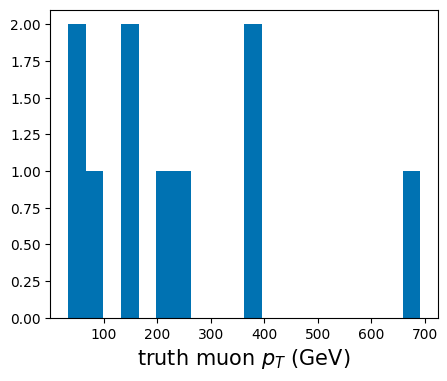

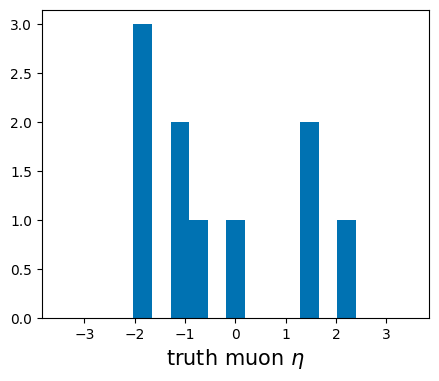

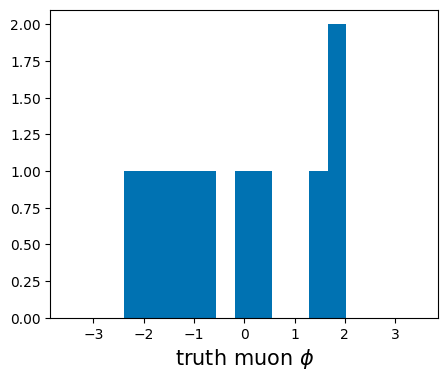

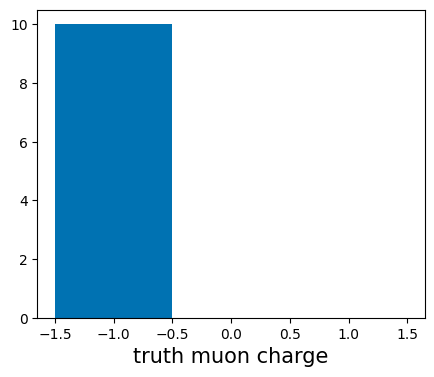

In [16]:

plot1DHistogram(truthMuons.pt     , bins=20  , label=";truth muon $p_{T}$ (GeV)")
plot1DHistogram(truthMuons.eta    , np.linspace(-3.5,3.5,20), label=";truth muon $\eta$")
plot1DHistogram(truthMuons.phi    , np.linspace(-3.5,3.5,20), label=";truth muon $\phi$")
plot1DHistogram(truthMuons.charge , np.linspace(-1.5,1.5,4) , label=";truth muon charge")


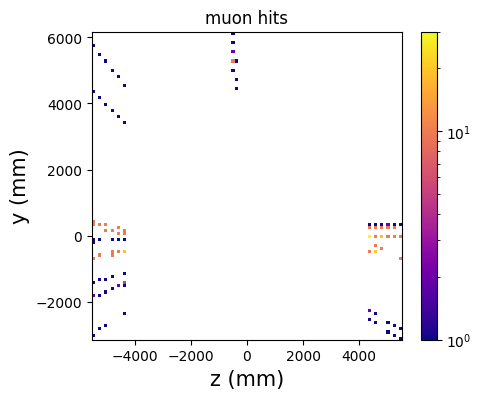

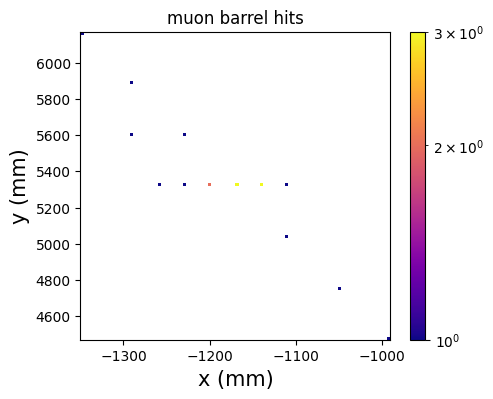

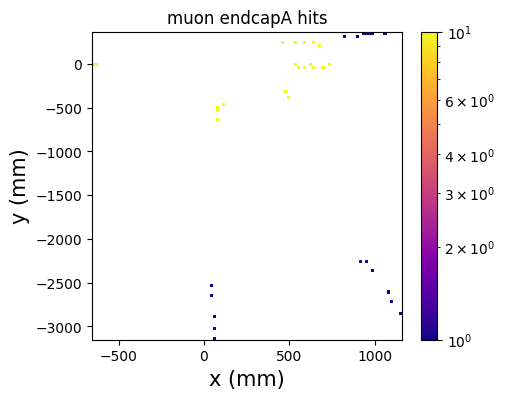

In [17]:
#plot muons
plot2DHistogram(muonHits.z, muonHits.y , bins=100, label="muon hits;z (mm);y (mm)")

# separate into barrel and endcap
barrel=abs(muonHits.z)<4000
endcapA=muonHits.z>4000
plot2DHistogram(muonHits.x[barrel], muonHits.y[barrel] , bins=100, label="muon barrel hits;x (mm);y (mm)")
plot2DHistogram(muonHits.x[endcapA], muonHits.y[endcapA] , bins=100, label="muon endcapA hits;x (mm);y (mm)")


## Plot tracks without any selections


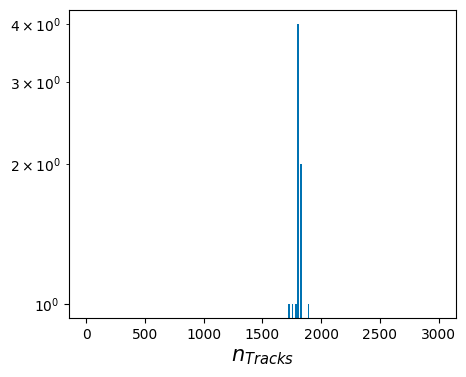

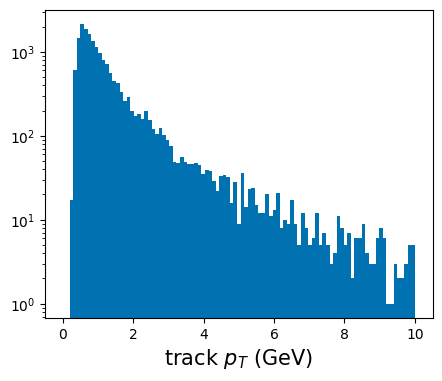

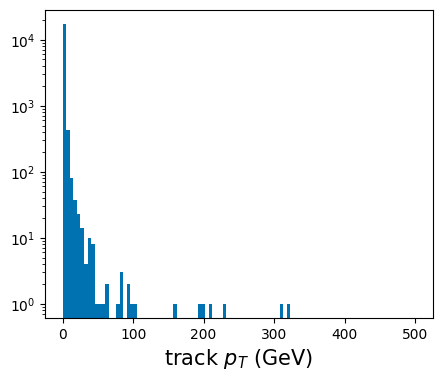

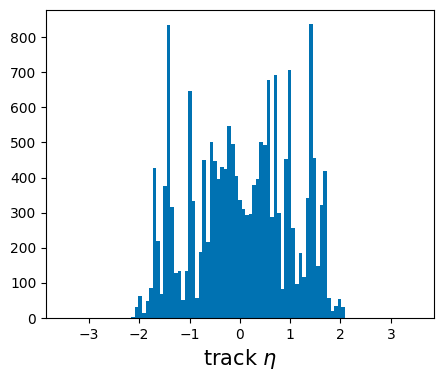

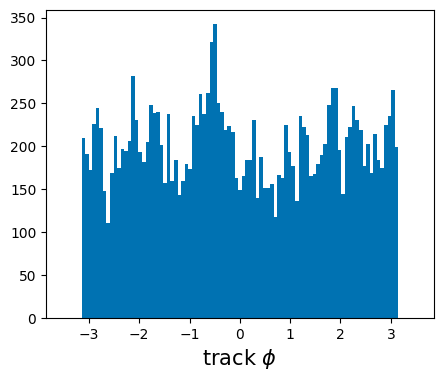

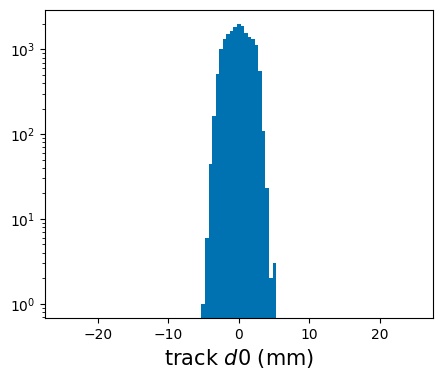

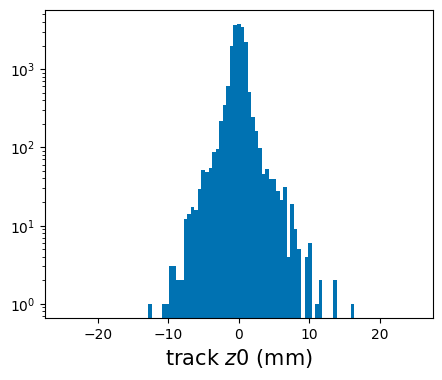

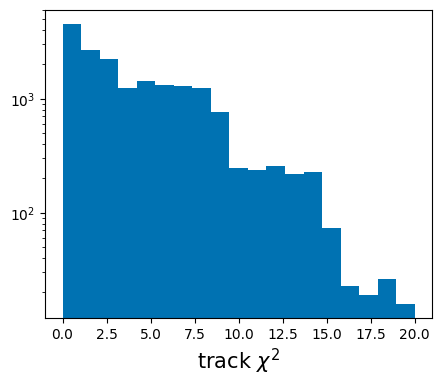

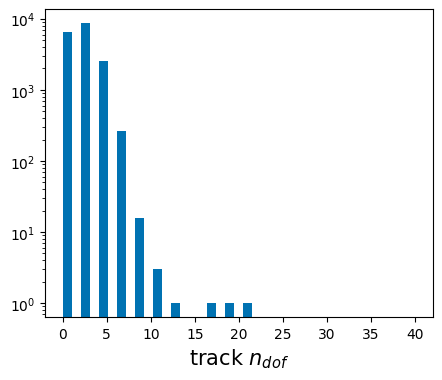

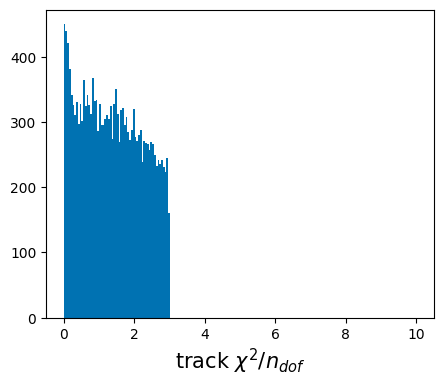

In [18]:

# basic kinematics
plot1DHistogram(ak.num(tracks) , bins=np.linspace(0,3000,200), scale='log', label=";$n_{Tracks}$")

plot1DHistogram(tracks.pt , bins=np.linspace(0,10,100), scale='log', label=";track $p_T$ (GeV)")
plot1DHistogram(tracks.pt , bins=np.linspace(0,500,100), scale='log', label=";track $p_T$ (GeV)")
plot1DHistogram(tracks.eta, bins=np.linspace(-3.5,3.5,100), label=";track $\eta$")
plot1DHistogram(tracks.phi, bins=np.linspace(-3.5,3.5,100), label=";track $\phi$")

# impact parameters, distance of closest approach
plot1DHistogram(tracks.d0, bins=np.linspace(-25,25,100), scale='log', label=";track $d{0}$ (mm)")
plot1DHistogram(tracks.z0, bins=np.linspace(-25,25,100), scale='log', label=";track $z{0}$ (mm)")

# quality variables
plot1DHistogram(tracks.chi2, bins=np.linspace(0,20,20), scale='log', label=";track $\chi^2$")
plot1DHistogram(tracks.ndf , bins=np.linspace(0,40,40), scale='log', label=";track $n_{dof}$")
plot1DHistogram(tracks.chi2/tracks.ndf, bins=np.linspace(0,10,200), label=";track $\chi^2/n_{dof}$")


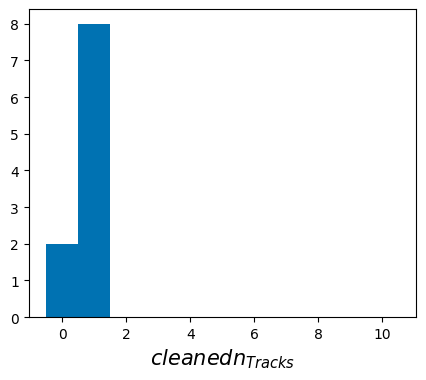

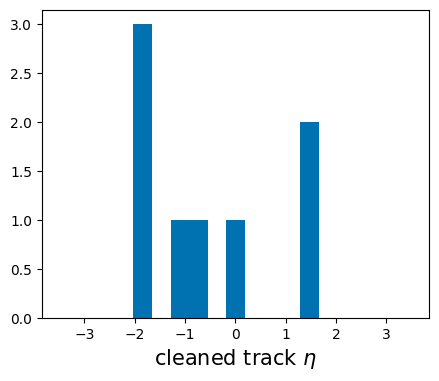

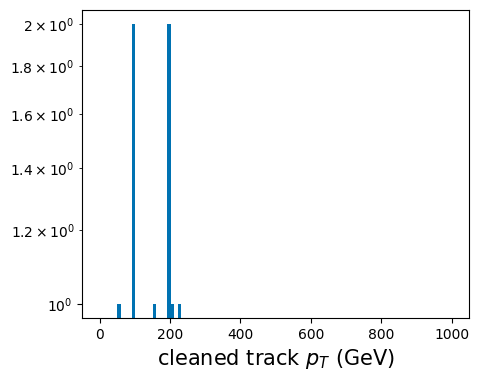

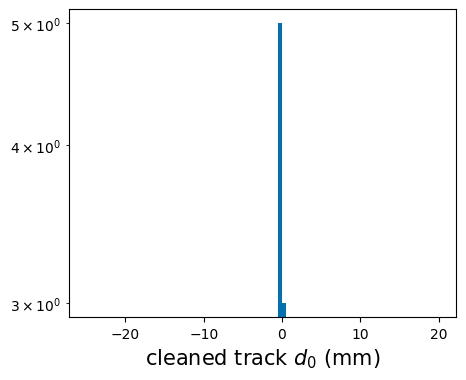

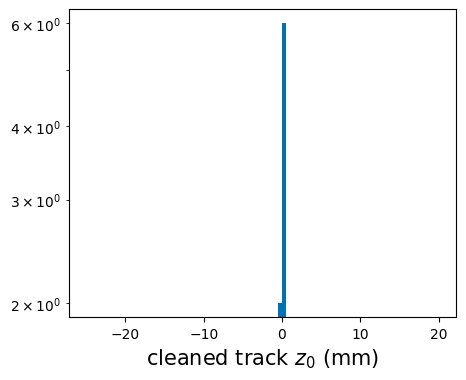

In [19]:
# try and select high quality tracks
clean=(tracks.ndf>7)&(tracks.pt>1) # use ndf as a proxy for-nhits

plot1DHistogram(ak.num(tracks[clean]), bins=np.linspace(-0.5,10.5,12), label=";$cleaned n_{Tracks}$")

plot1DHistogram(tracks.eta[clean], bins=np.linspace(-3.5,3.5,20), label=";cleaned track $\eta$")
plot1DHistogram(tracks.pt[clean], bins=np.linspace(0,1000,100), scale='log', label=";cleaned track $p_{T}$ (GeV)")

plot1DHistogram(tracks.d0[clean], bins=np.linspace(-25,20,100), scale='log', label=";cleaned track $d_0$ (mm)")
plot1DHistogram(tracks.z0[clean], bins=np.linspace(-25,20,100), scale='log', label=";cleaned track $z_0$ (mm)")



#  Now try to match truth muons to tracks

Match truth muons to the track closest in $\Delta R= \sqrt {\Delta\eta)^2 +(\Delta\phi)^2}$

Compare 'truth matched' tracks to 'unmatched' tracks. Note down differences in pt, eta, phi, quality of fit, number of hits on track etc. How do these differences compare to the 'track cleaning' from before?

Do the same for Muon Hits, what rate of muon hits are not matched to a collision particle?

In [20]:
cleanTracks=tracks[(tracks.ndf>5)&(tracks.pt>1)] # to start, leave cut on ndf a little loose

all_pairs = ak.cartesian([cleanTracks,truthMuons])

In [22]:
# Test that it did what we want
for i in range(0,10):
    print(i, all_pairs[i])

0 [({pt: 1, theta: 1.88, ...}, {px: 1.09, ...}), (..., ...), ({...}, {...})]
1 [({pt: 232, theta: 2.79, ...}, {px: 231, ...})]
2 [({pt: 1, theta: 1.88, ...}, {px: -146, ...}), (..., ...), ({...}, {...})]
3 [({pt: 91.3, theta: 2.48, ...}, {px: 7.26, ...})]
4 [({pt: 60.4, theta: 2.8, ...}, {px: 40.9, ...})]
5 [({pt: 1.27, theta: 2.45, ...}, {px: 31.5, ...}), ({...}, {...})]
6 [({pt: 1.06, theta: 2.4, ...}, {px: -48.1, ...}), ({...}, {...})]
7 [({pt: 211, theta: 0.508, ...}, {px: 77.9, ...})]
8 [({pt: 1.06, theta: 2.49, ...}, {px: -260, ...})]
9 [({pt: 158, theta: 2.8, phi: ..., ...}, {px: -63.5, ...})]


In [23]:
# Now unzip for computing angles
trks, mus = ak.unzip(all_pairs)

# Identify pair with the minimum dR
dRs = trks.deltaR(mus)
which = ak.argmin(abs(dRs), axis=1, keepdims=True) 

# also require dR < 0.1
dRcut = dRs[which]<0.1
matched = which[dRcut]

for i in range(0,10):
    print(i, dRs[i], which[i], matched[i], trks[matched][i].pt, mus[matched][i].pt)

0 [1.68, 3.16, 0.000579] [2] [2] [197] [155]
1 [3.62e-05] [0] [0] [232] [231]
2 [2.57, 0.000962, 2.08] [1] [1] [98.1] [692]
3 [5.95e-05] [0] [0] [91.3] [91.2]
4 [7.5e-05] [0] [0] [60.4] [60.4]
5 [3.4, 2.97] [1] [] [] []
6 [2.67, 0.000556] [1] [1] [198] [372]
7 [2.73e-05] [0] [0] [211] [209]
8 [0.701] [0] [] [] []
9 [0.000127] [0] [0] [158] [162]


In [24]:
# a handy plotting function
colors = []
def compare1DHistograms(datas,bins,scale='linear',label="",leg=[]):

    fig = plt.figure(figsize=(5,4))
    ax = fig.add_subplot(111)
    
    for i,data in enumerate(datas): 

        # handle data, there must be a smarter way to do this...
        if type(data[0])==np.int64   : data_flat=data
        elif type(data[0])==np.float32 : data_flat=data
        else : data_flat = ak.flatten(data, axis=None)
            
        ax.hist(data_flat, bins, alpha=0.5, label=leg[i] if len(leg)>i else "")
   
    # handle labels
    title  = "" if len(label.split(";")) < 1 else label.split(";")[0]  
    xlabel = "" if len(label.split(";")) < 2 else label.split(";")[1]  
    ylabel = "" if len(label.split(";")) < 3 else label.split(";")[2] 
    
    ax.set_title(title)
    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_ylabel(ylabel, fontsize=15)
    plt.legend()
    plt.yscale(scale)
    plt.show()

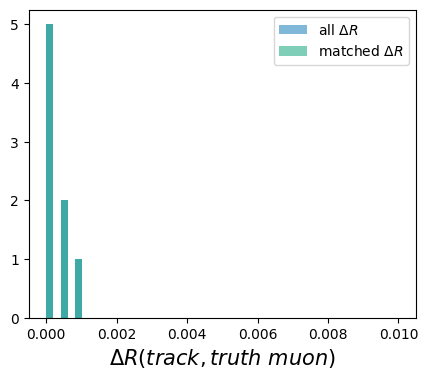

In [30]:
# plot all dRs

arrays = [dRs,dRs[matched]]
legends= ["all $\Delta R$", "matched $\Delta R$"]

compare1DHistograms(arrays, bins=np.linspace(0,.01,50), leg=legends, label=";$\Delta R(track, truth~muon)$")


# Follow up

Investigate the following
* Efficiency: What fraction of truth muons were reconstructed as 'clean tracks'?
* Fake rate: What fraction of clean tracks were not matched to a truth muon?
* How would loosening your clean track selection improve efficiency? improve your fake rate?
* How close are the reconstructed tracks parameters to those of the truth muon? eg. pT, eta, phi, etc

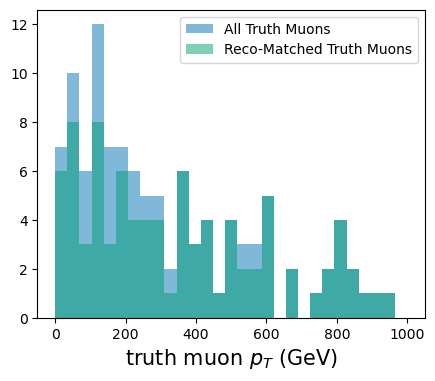

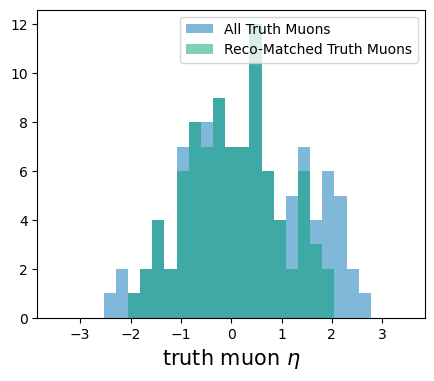

In [36]:
# Steps towards efficiency
recodMuons = mus[matched]

arrays = [truthMuons.pt,recodMuons.pt]
legend = [ "All Truth Muons","Reco-Matched Truth Muons"]
compare1DHistograms(arrays, bins=np.linspace(0,1000,30), leg=legend, label=";truth muon $p_{T}$ (GeV)")

arrays = [truthMuons.eta,recodMuons.eta]
legend = [ "All Truth Muons","Reco-Matched Truth Muons"]
compare1DHistograms(arrays, bins=np.linspace(-3.5,3.5,30), leg=legend, label=";truth muon $\eta$")

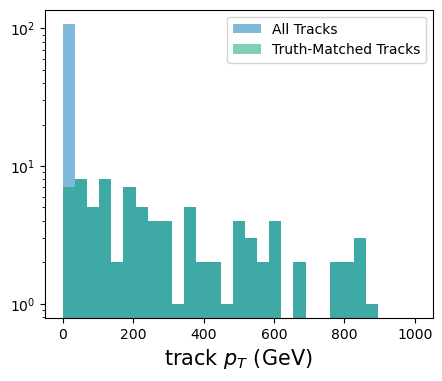

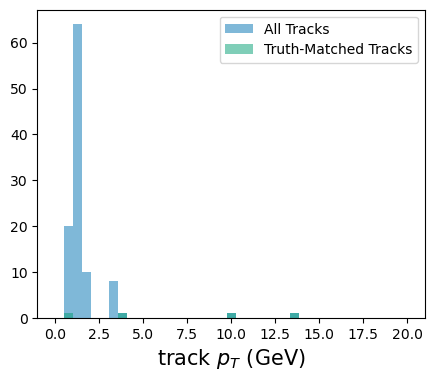

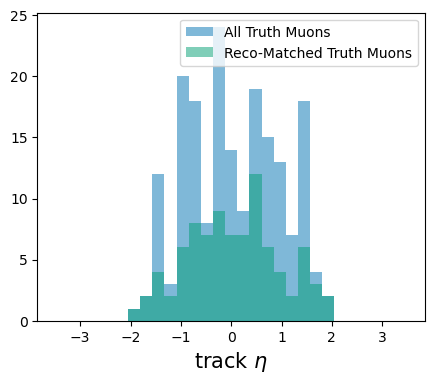

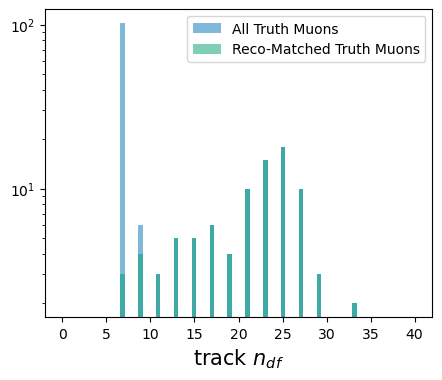

In [37]:
# Steps towards fake rate
matchedTracks = trks[matched]

arrays = [cleanTracks.pt,matchedTracks.pt]
legend = [ "All Tracks","Truth-Matched Tracks"]
compare1DHistograms(arrays, bins=np.linspace(0,1000,30), leg=legend, scale='log',label=";track $p_{T}$ (GeV)")
compare1DHistograms(arrays, bins=np.linspace(0,20,40), leg=legend, label=";track $p_{T}$ (GeV)")

arrays = [cleanTracks.eta,matchedTracks.eta]
legend = [ "All Truth Muons","Reco-Matched Truth Muons"]
compare1DHistograms(arrays, bins=np.linspace(-3.5,3.5,30), leg=legend, label=";track $\eta$")

arrays = [cleanTracks.ndf,matchedTracks.ndf]
legend = [ "All Truth Muons","Reco-Matched Truth Muons"]
compare1DHistograms(arrays, bins=np.linspace(0,40,80), leg=legend, scale='log', label=";track $n_{df}$")